<a href="https://colab.research.google.com/github/AidarZhumekenov/ML-labs/blob/master/UFC%20final%20project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
fighter_db = pd.read_csv('https://raw.githubusercontent.com/jasonchanhku/UFC-MMA-Predictor/master/Datasets/UFC_Fighters_Database.csv')
fighter_db.head()

,NAME,Weight,WeightClass,REACH,SLPM,SAPM,STRA,STRD,TD,TDA,TDD,SUBA
0,Tom Aaron,155,lightweight,71,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
1,Danny Abbadi,155,lightweight,71,3.29,4.41,0.38,0.57,0.00,0.00,0.77,0.0
2,David Abbott,265,heavyweight,77,1.35,3.55,0.30,0.38,1.07,0.33,0.66,0.0
3,Shamil Abdurakhimov,235,heavyweight,76,2.53,2.53,0.45,0.58,1.36,0.22,0.77,0.3
4,Hiroyuki Abe,145,featherweight,70,1.71,3.11,0.36,0.63,0.00,0.00,0.33,0.0


In [0]:
fights_db = pd.read_csv('https://raw.githubusercontent.com/jasonchanhku/UFC-MMA-Predictor/master/Datasets/UFC_Fights.csv')
fights_db.head()

,RecordID,Events,Fighter1,Fighter2,Winner,fighter1_odds,fighter2_odds,F1 or F2,Label,Combine,Favourite,Underdog
0,1,UFC 159 - Jones vs. Sonnen,Jon Jones,Chael Sonnen,Jon Jones,1.13,9.00,1,Favourite,Favourite 1,Jon Jones,Chael Sonnen
1,2,UFC 159 - Jones vs. Sonnen,Michael Bisping,Alan Belcher,Michael Bisping,1.57,4.50,1,Favourite,Favourite 1,Michael Bisping,Alan Belcher
2,3,UFC 159 - Jones vs. Sonnen,Roy Nelson,Cheick Kongo,Roy Nelson,1.43,3.20,1,Favourite,Favourite 1,Roy Nelson,Cheick Kongo
3,4,UFC 159 - Jones vs. Sonnen,Phil Davis,Vinny Magalhaes,Phil Davis,1.36,3.55,1,Favourite,Favourite 1,Phil Davis,Vinny Magalhaes
4,5,UFC 159 - Jones vs. Sonnen,Pat Healy,Jim Miller,Pat Healy,3.40,1.40,1,Underdog,Underdog 1,Jim Miller,Pat Healy


In [0]:
df = pd.read_csv('https://raw.githubusercontent.com/jasonchanhku/UFC-MMA-Predictor/master/Datasets/Cleansed_Data.csv')
df = df.drop('Sum_delta', axis=1)
df.head()

,Events,Favourite,Underdog,Label,REACH_delta,SLPM_delta,SAPM_delta,STRA_delta,STRD_delta,TD_delta,TDA_delta,TDD_delta,SUBA_delta,Odds_delta
0,UFC 159 - Jones vs. Sonnen,Jon Jones,Chael Sonnen,Favourite,10,1.17,0.90,0.12,0.03,-1.56,-0.07,0.28,0.2,-7.87
1,UFC 159 - Jones vs. Sonnen,Leonard Garcia,Cody McKenzie,Underdog,-3,1.03,2.29,-0.10,-0.15,-2.20,0.01,0.28,-2.0,1.40
2,UFC Fight Night 34 - Saffiedine vs. Lim,Mairbek Taisumov,Tae Hyun Bang,Favourite,2,0.54,0.08,0.05,-0.05,1.75,0.44,0.28,-0.5,-2.89
3,UFC Fight Night 91 - McDonald vs. Lineker,Cody Pfister,Scott Holtzman,Underdog,4,-3.15,-0.85,-0.24,-0.06,0.55,-0.27,-0.58,-0.4,6.89
4,UFC Fight Night 91 - McDonald vs. Lineker,Matthew Lopez,Rani Yahya,Underdog,2,0.02,0.86,0.13,-0.06,-0.08,0.51,0.37,-0.5,0.81


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplot
import seaborn as sns
import scipy.stats as stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, cross_val_predict
from sklearn.feature_selection import RFECV
from sklearn.metrics import roc_auc_score, classification_report, make_scorer, accuracy_score
import warnings
import time
warnings.filterwarnings('ignore')
%matplotlib inline

#Progress bar
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

# Creating Dummies
def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [0]:
# Shape of df
df.shape

(1315, 14)

In [0]:
# Data types of 
df.dtypes

Events          object
Favourite       object
Underdog        object
Label           object
REACH_delta      int64
SLPM_delta     float64
SAPM_delta     float64
STRA_delta     float64
STRD_delta     float64
TD_delta       float64
TDA_delta      float64
TDD_delta      float64
SUBA_delta     float64
Odds_delta     float64
dtype: object

In [0]:
# What percentage of Favourite fighters win?
df['Label'].value_counts()

Favourite    825
Underdog     490
Name: Label, dtype: int64

In [0]:
a = df['Label'].value_counts()/len(df)
a

Favourite    0.627376
Underdog     0.372624
Name: Label, dtype: float64

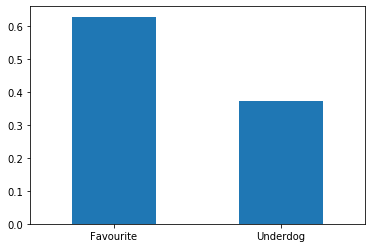

In [0]:
a.plot(kind='bar', rot=0)

In [0]:
# Statistical overview of dataset
df.describe()

,REACH_delta,SLPM_delta,SAPM_delta,STRA_delta,STRD_delta,TD_delta,TDA_delta,TDD_delta,SUBA_delta,Odds_delta
count,1315.000000,1315.000000,1315.000000,1315.000000,1315.000000,1315.000000,1315.000000,1315.000000,1315.000000,1315.000000
mean,0.219011,0.264205,-0.302084,0.013338,0.017886,0.280897,0.052259,0.055749,0.103194,-0.859810
std,3.321775,1.475753,1.571591,0.111590,0.104947,1.886774,0.286079,0.299480,1.173894,2.313673
min,-10.000000,-6.020000,-10.560000,-0.490000,-0.350000,-10.750000,-1.000000,-1.000000,-12.100000,-12.950000
25%,-2.000000,-0.620000,-1.110000,-0.060000,-0.050000,-0.900000,-0.120000,-0.120000,-0.500000,-1.940000
50%,0.000000,0.300000,-0.200000,0.010000,0.020000,0.240000,0.040000,0.040000,0.000000,-0.780000
75%,2.000000,1.175000,0.605000,0.080000,0.090000,1.365000,0.225000,0.230000,0.600000,0.575000
max,12.000000,7.480000,7.910000,0.570000,0.420000,9.780000,1.000000,1.000000,11.800000,7.380000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f174127f898>,
      dtype=object)

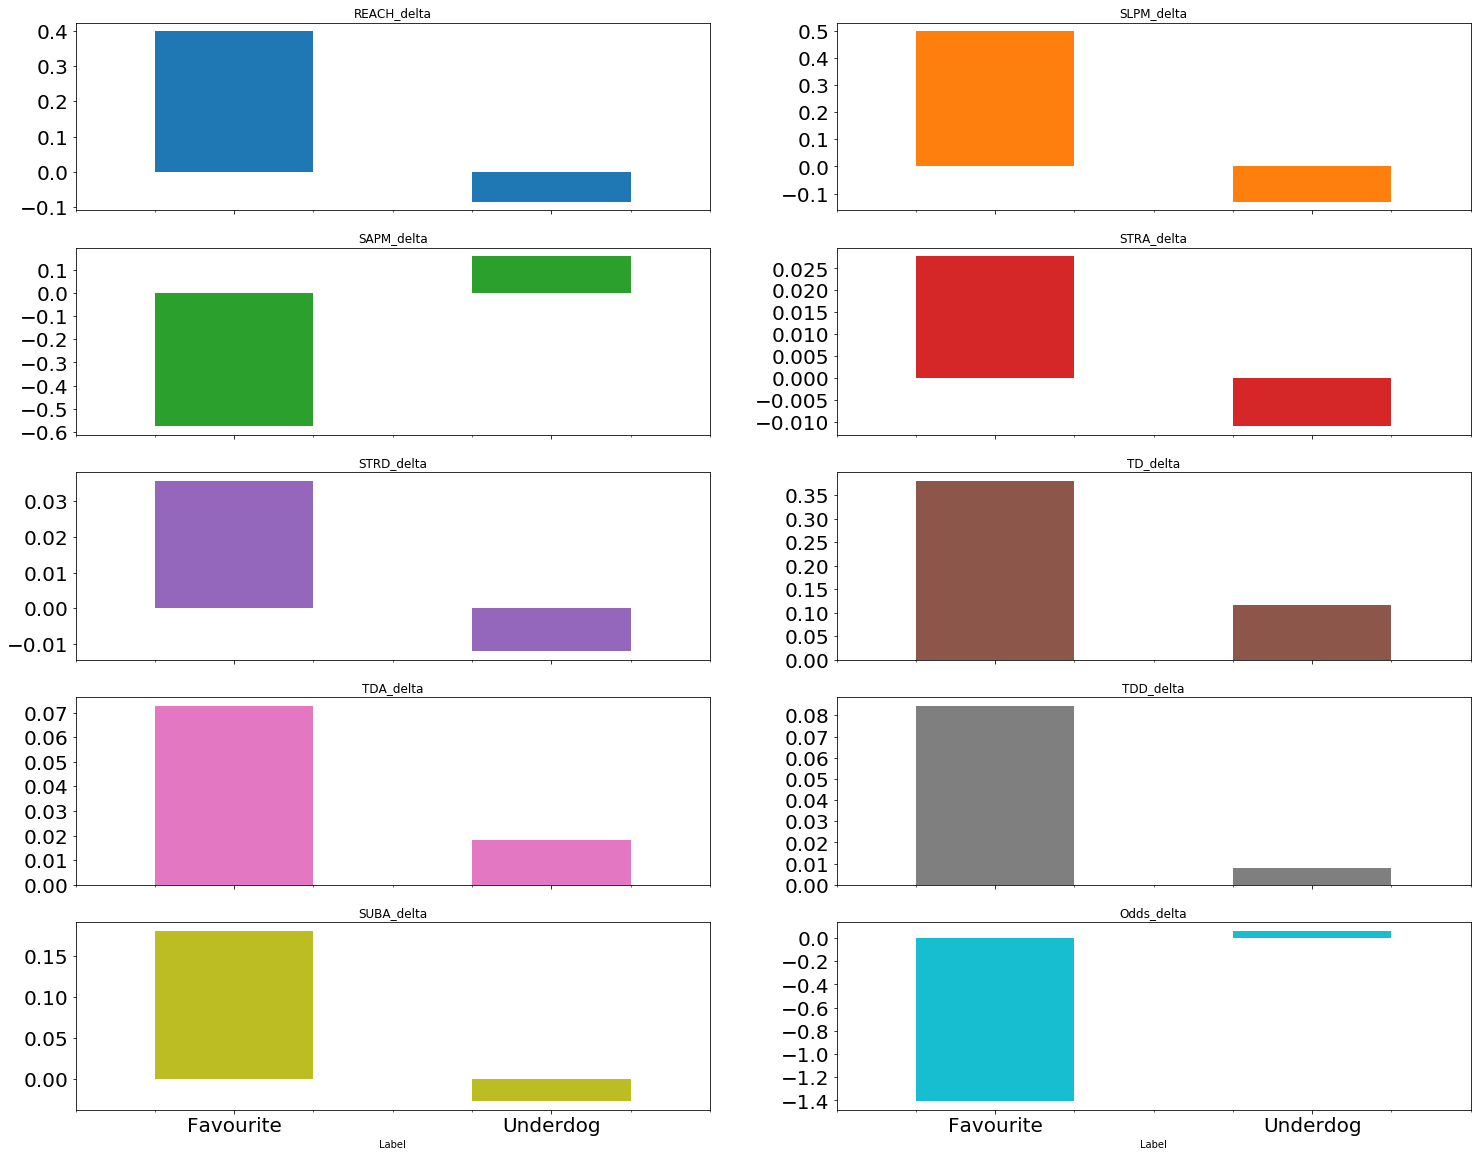

In [0]:

# Does mean of each feature distinguish the Favourite / Underdog to win ?
# Does a specific feature advantage give the underdog winners an edge ?
df.groupby('Label').mean().plot(kind = 'bar', subplots=True, layout=(5,2), legend=False, figsize=(25,20), fontsize=20, rot=0)

In [0]:
def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

# Correlation Matrix
df_corr = create_dummies(df, 'Label').drop('Label_Underdog', axis = 1)
corr = df_corr.corr()
corr = (corr)
corr

,REACH_delta,SLPM_delta,SAPM_delta,STRA_delta,STRD_delta,TD_delta,TDA_delta,TDD_delta,SUBA_delta,Odds_delta,Label_Favourite
REACH_delta,1.000000,0.037076,-0.077292,-0.042400,-0.090796,-0.078721,0.027693,-0.072749,0.060381,-0.030485,0.070252
SLPM_delta,0.037076,1.000000,0.089550,0.361854,0.268306,-0.167199,0.041915,0.195507,-0.167117,-0.154969,0.205441
SAPM_delta,-0.077292,0.089550,1.000000,-0.298355,-0.412943,-0.280762,-0.230730,-0.064397,-0.040124,0.148382,-0.226802
STRA_delta,-0.042400,0.361854,-0.298355,1.000000,0.114704,0.202333,0.246022,0.143988,0.038443,-0.103734,0.168435
STRD_delta,-0.090796,0.268306,-0.412943,0.114704,1.000000,0.043988,0.128065,0.188816,-0.153664,-0.111798,0.220450
TD_delta,-0.078721,-0.167199,-0.280762,0.202333,0.043988,1.000000,0.427436,0.003178,0.192474,-0.072800,0.067313
TDA_delta,0.027693,0.041915,-0.230730,0.246022,0.128065,0.427436,1.000000,0.221375,0.098257,-0.106092,0.091885
TDD_delta,-0.072749,0.195507,-0.064397,0.143988,0.188816,0.003178,0.221375,1.000000,-0.157317,-0.101961,0.123448
SUBA_delta,0.060381,-0.167117,-0.040124,0.038443,-0.153664,0.192474,0.098257,-0.157317,1.000000,-0.047820,0.085332
Odds_delta,-0.030485,-0.154969,0.148382,-0.103734,-0.111798,-0.072800,-0.106092,-0.101961,-0.047820,1.000000,-0.306930


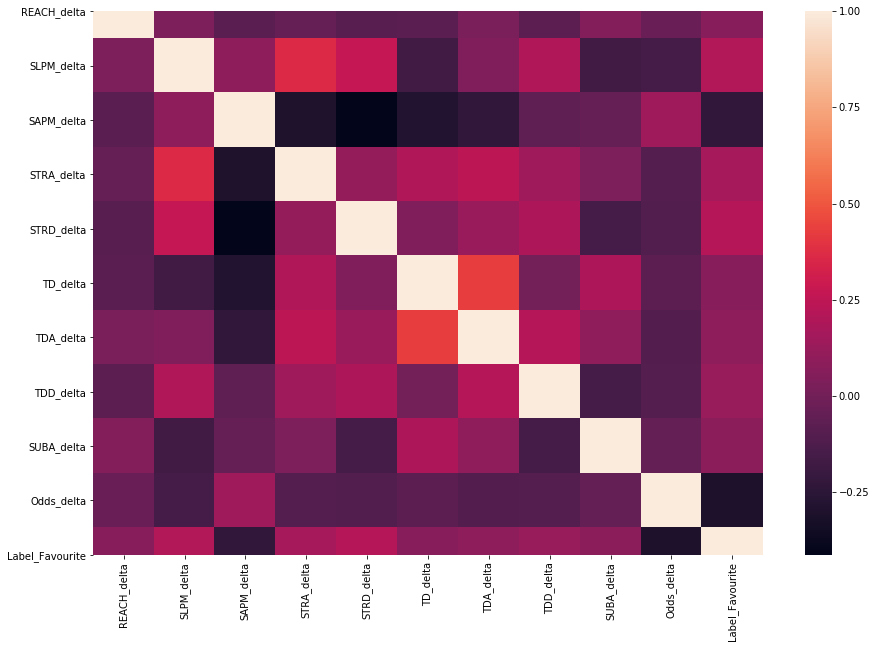

In [0]:
plt.figure(figsize=(15,10))
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [0]:
# Compating both means

print('STRD_delta mean of favourite winners is: ' +  '{}' .format(df['STRD_delta'][df['Label'] == 'Favourite'].mean()))
print('STRD_delta mean of undersog winners is: ' + '{}'.format(df['STRD_delta'][df['Label'] == 'Underdog'].mean()))

# However, is the marginal difference of 0.047 significant?

STRD_delta mean of favourite winners is: 0.03570909090909092
STRD_delta mean of undersog winners is: -0.012122448979591837


In [0]:
# T-test
stats.ttest_1samp(a=  df[df['Label']=='Favourite']['STRD_delta'], # Sample of Favourite winners
                  popmean = df['STRD_delta'].mean())  # Fighter population mean

Ttest_1sampResult(statistic=4.987525562089509, pvalue=7.45998762740658e-07)

In [0]:
# Critical point 
degree_freedom = len(df[df['Label']=='Favourite'])

LQ = stats.t.ppf(0.025,degree_freedom)  # Left Quartile

RQ = stats.t.ppf(0.975,degree_freedom)  # Right Quartile

print ('The t-distribution left quartile range is: ' + str(LQ))
print ('The t-distribution right quartile range is: ' + str(RQ))

The t-distribution left quartile range is: -1.962843616296083
The t-distribution right quartile range is: 1.9628436162960825


In [0]:
cols = df.drop(['Events', 'Favourite', 'Underdog', 'Label'], axis =1).columns.tolist()

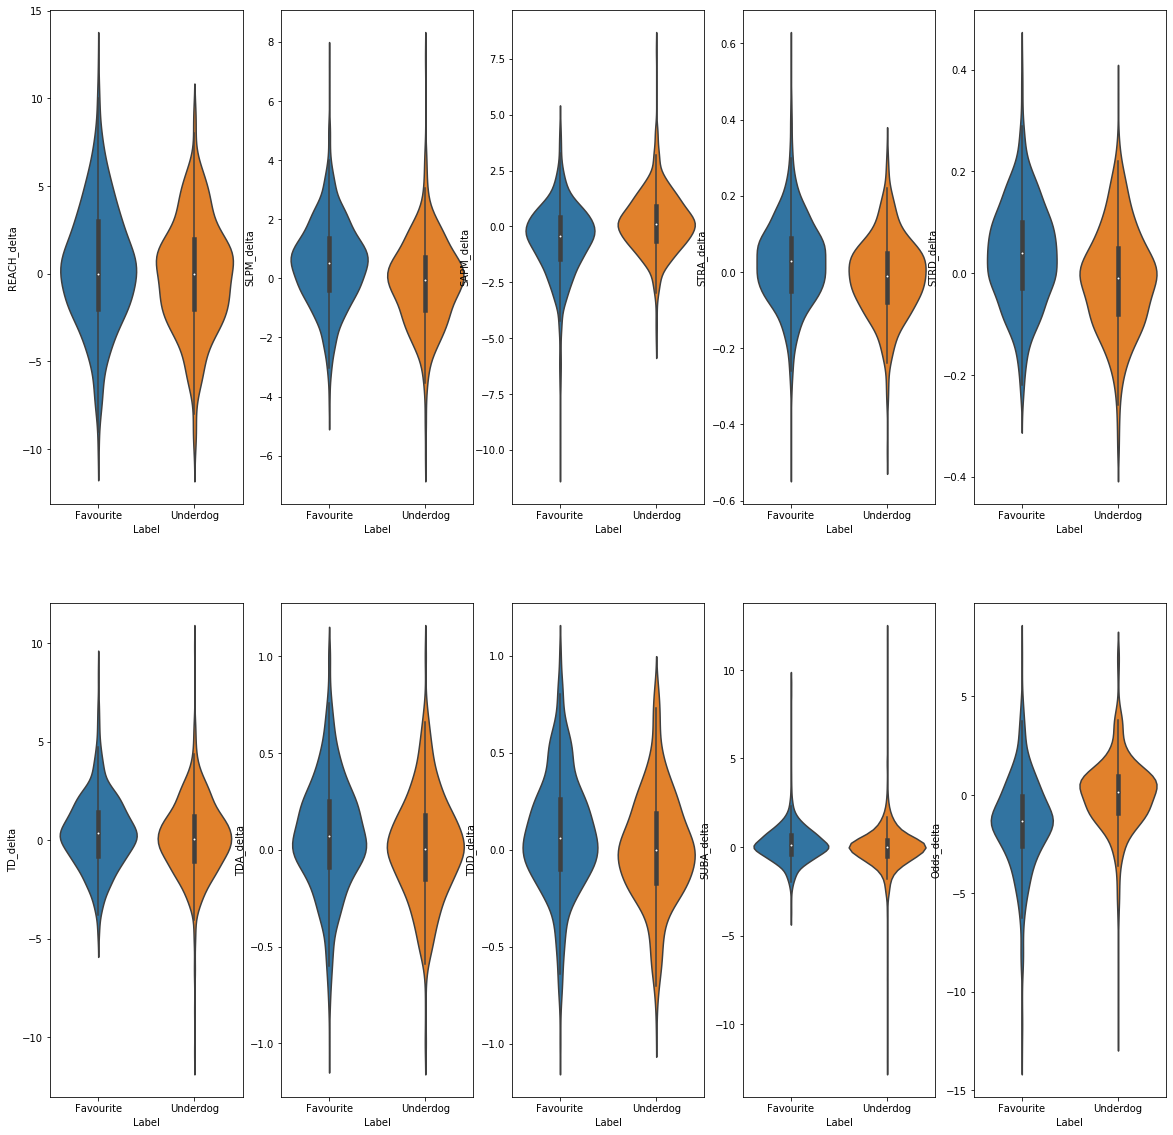

In [0]:
# create 10 plots with a 2 by 5 dimension subplots
fig, ax = plt.subplots(2,5, figsize=(20,20))

# loop to plot in subplots
for i, col in enumerate(cols):
    x = i // 5
    y = i % 5
    sns.violinplot(x="Label", y=col , data=df, order=["Favourite", "Underdog"], ax=ax[x,y])

In [0]:
# Create a function to select features
# Note that feature names are stored in cols

def select_features(df):
    all_X = df.drop(['Events', 'Favourite', 'Underdog', 'Label'], axis=1)
    all_y = df['Label']
    
    clf = RandomForestClassifier(random_state=1)
    selector = RFECV(clf)
    selector.fit(all_X, all_y)
    best_columns = list(all_X.columns[selector.support_])
    print('Best Columns \n' + '-'*12 + '\n' + '{}'.format(best_columns))
    
    return best_columns

In [0]:
best_cols = select_features(df)

Best Columns 
------------
['SLPM_delta', 'SAPM_delta', 'STRD_delta', 'TD_delta', 'Odds_delta']


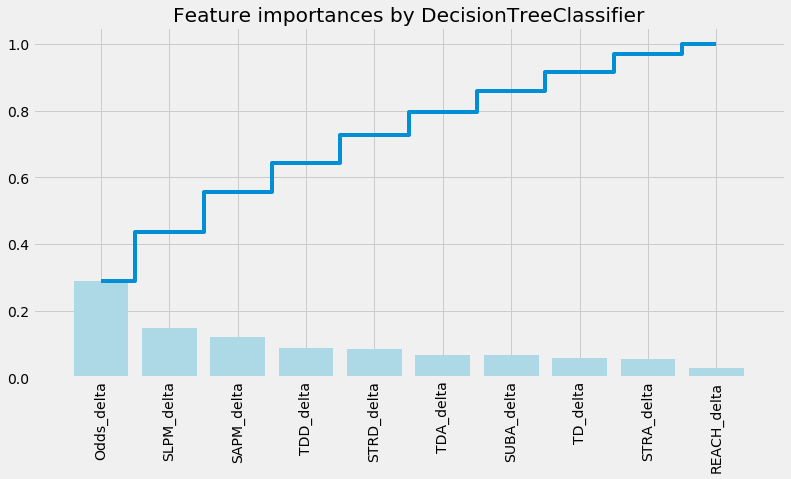

In [0]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12,6)

# Create train and test splits
target_name = 'Label'
X = df.drop(['Events', 'Favourite', 'Underdog', 'Label'], axis=1)


y=df[target_name]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15, random_state=1, stratify=y)

dtree = RandomForestClassifier(
    #max_depth=3,
    random_state = 1,
    class_weight="balanced",
    min_weight_fraction_leaf=0.01
    )
dtree = dtree.fit(X_train,y_train)

## plot the importances ##
importances = dtree.feature_importances_
feat_names = df.drop(['Events', 'Favourite', 'Underdog', 'Label'], axis=1).columns


indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12,6))
plt.title("Feature importances by DecisionTreeClassifier")
plt.bar(range(len(indices)), importances[indices], color='lightblue',  align="center")
plt.step(range(len(indices)), np.cumsum(importances[indices]), where='mid', label='Cumulative')
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical',fontsize=14)
plt.xlim([-1, len(indices)])
plt.show()

In [0]:
def select_model(df, features):
    
    all_X = df[features]
    all_y = df["Label"]
    #create a list of dics which contains models and hyperparameters
    models = [
        
        {
            "name": "Logistic Regression",
            "estimator": LogisticRegression(),
            "hyperparameters":
            {
             "solver": ["newton-cg", "lbfgs", "liblinear"]   
            }
            
        },

        {
            "name": "RandomForestClassifier",
            "estimator": RandomForestClassifier(random_state=1),
            "hyperparameters":
                {
                    "n_estimators": [4, 6, 9],
                    "criterion": ["entropy", "gini"],
                    "max_depth": [2, 5, 10],
                    "max_features": ["log2", "sqrt"],
                    "min_samples_leaf": [1, 5, 8],
                    "min_samples_split": [2, 3, 5]

                }
        },
                {
            "name": "Multi Layer Perceptron (MLP)",
            "estimator": MLPClassifier(random_state=1),
            "hyperparameters":
                {
                    "hidden_layer_sizes": [(5,5), (10,10)],
                    "activation": ["relu", "tanh", "logistic"],
                    "solver": ['sgd', 'adam'],
                    "learning_rate": ["constant", "adaptive"]

                }
        } 
    ]
    
    for model in log_progress(models):
        print(model["name"])
        print("-"*len(model["name"]))
        
        grid = GridSearchCV(model["estimator"],
                            param_grid=model["hyperparameters"],
                            cv=10, scoring = 'accuracy')
        grid.fit(all_X,all_y)
        model["best_params"] = grid.best_params_
        model["best_score"] = grid.best_score_
        model["best_model"] = grid.best_estimator_
        model["scoring"] = grid.scorer_
        
        print("Best Paramerters:\n" + "{}".format(model["best_params"]))
        print("Best Score:\n" + "{}".format(model["best_score"]))
        print("Best Model:\n" + "{}\n".format(model["best_model"]))
        print("Scoring method:\n" + "{}\n".format(model["scoring"]))
        
    return models

In [0]:

models = select_model(df, best_cols)

Logistic Regression
-------------------
Best Paramerters:
{'solver': 'liblinear'}
Best Score:
0.6828897338403042
Best Model:
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

Scoring method:
make_scorer(accuracy_score)

RandomForestClassifier
----------------------
Best Paramerters:
{'criterion': 'entropy', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 6}
Best Score:
0.694296577946768
Best Model:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=5, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_sam